In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import scipy.sparse
import pickle
import requests
import seaborn as sns
import nltk
import lightgbm as lgb
from nltk.tokenize import sent_tokenize, word_tokenize
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.utils import resample

In [47]:
ts = pd.read_csv("bu_athletics_data.csv")
print(ts.shape[0], 'rows', ts.shape[1], 'columns')
print(ts.columns)

993 rows 74 columns
Index(['Data Input Year', 'Student', 'State', 'US Region', 'Country',
       'English Language Primary Language of Country',
       'IPEDS Race Description', 'Athletic Code 1', 'Team Gender',
       'Athletic Code Description 1', 'HYR', 'Entering Term', 'Yr', 'FCLASS',
       'RetentionClass', 'ACADINDEX', 'SATCFORAI', 'ACTUSE', 'SATCUSE',
       'SATVUSE', 'satm', 'satwr', 'HSGPA', 'FIRSTCOLLEGE', 'FIRSTMAJOR',
       'First Major (HEGIS) Description', 'LASTCOLLEGE', 'LASTMAJOR',
       'Last Major (HEGIS) Description', 'Last Cumulative BU GPA',
       'Cumulative GPA-1st Sem', 'Cumulative GPA-2nd Sem',
       'Cumulative GPA-3rd Sem', 'Cumulative GPA-4th Sem',
       'Cumulative GPA-5th Sem', 'Cumulative GPA-6th Sem',
       'Cumulative GPA-7th Sem', 'Cumulative GPA-8th Sem',
       'Cumulative GPA-9th Sem', 'Cumulative GPA-10th Sem',
       'Cumulative GPA-11th Sem', 'Cumulative GPA-12th Sem',
       'Cumulative GPA-13th Sem', 'Cumulative GPA-14th Sem',
       'C

In [48]:
ranks = pd.read_csv('rankings.csv')
ranks.columns

Index(['Athletic Code Description 1', 'Rank', 'Win%'], dtype='object')

In [49]:
ts.head()

,Data Input Year,Student,State,US Region,Country,English Language Primary Language of Country,IPEDS Race Description,Athletic Code 1,Team Gender,Athletic Code Description 1,...,Semester GPI-13th Sem,Semester GPI-14th Sem,Semester GPI-15th Sem,Semester GPI-16th Sem,Semester GPI-17th Sem,Semester GPI-18th Sem,Semester GPI-19th Sem,Semester GPI-20th Sem,Semester GPI-21st Sem,Semester GPI-22nd Sem
0,2022,1,NaN,NaN,Canada,English,Non-Resident Alien,HC,M,MEN'S ICE HOCKEY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,2,CT,NaN,NaN,NaN,African American or Black,SC,M,MEN'S SOCCER,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023,3,CA,NaN,NaN,NaN,White,MC,M,MEN'S ROWING,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,14,NaN,NaN,Italy,Non-English,Non-Resident Alien,SC,M,MEN'S SOCCER,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023,15,NaN,NaN,Germany,Non-English,Non-Resident Alien,MC,M,MEN'S ROWING,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Processing

In [50]:
ts['GPA>3.5'] = ts['Last Cumulative BU GPA'] >= 3.5
ts['GPA>3.5'] = ts['GPA>3.5'].astype(int)
# ts.drop(columns=['US Region'], inplace=True)
ts['English Language Primary Language of Country'].fillna('English', inplace=True)
ts['Country'].fillna('USA', inplace=True)
ts['Team Gender'].replace(to_replace=['M', 'W'], value=[1, 0], inplace=True)
ts['ACADINDEX'].fillna(ts['ACADINDEX'].mean(), inplace=True)
ts['SATCFORAI'].fillna(ts['SATCFORAI'].mean(), inplace=True)
ts['ChangedMajor'] = ts['FIRSTMAJOR'] != ts['LASTMAJOR']
ts['ChangedMajor'] = ts['ChangedMajor'].astype(int)
ts['HSGPA'].fillna(ts['HSGPA'].mean(), inplace=True)
ts['Semester GPI-1st Sem'].fillna(ts['Semester GPI-1st Sem'].mean(), inplace=True)
ts['Semester GPI-2nd Sem'].fillna(ts['Semester GPI-2nd Sem'].mean(), inplace=True)

In [51]:
ne_states = ["PA", "DE", "MD", "MA", "VT", "NJ", "ME", "CT", "NY", "NH", "RI"]
sw_states = ["TX", "AZ", "NM", "OK"]
mw_states = ["IL", "IN", "IA", "KS", "MI", "MN", "MO", "NE", "ND", "OH", "SD", "WI"]
w_states = ["AK", "CA", "CO", "HI", "ID", "MT", "NV", "OR", "UT", "WA", "WY"]
s_states = ["AR", "KY", "VA", "FL", "NC", "LA", "WV", "SC", "TN", "AL", "MS", "GA"]

ts['NE_State'] = ts['State'].apply(lambda x : 1 if x in ne_states else 0)
ts['SW_State'] = ts['State'].apply(lambda x : 1 if x in sw_states else 0)
ts['MW_State'] = ts['State'].apply(lambda x : 1 if x in mw_states else 0)
ts['W_State'] = ts['State'].apply(lambda x : 1 if x in w_states else 0)
ts['S_State'] = ts['State'].apply(lambda x : 1 if x in s_states else 0)

In [52]:
ts = ts.join(ranks.set_index('Athletic Code Description 1'), on='Athletic Code Description 1')
ts['Rank'].fillna(ts['Rank'].mean(), inplace=True)

In [55]:
ts['Win%'].fillna(ts['Win%'].mean(), inplace=True)

In [56]:
ts.to_csv("processed_bu_athletics_data.csv", index=False)

### Building Model

In [57]:
ts = pd.read_csv("processed_bu_athletics_data.csv")

In [58]:
ts.columns

Index(['Data Input Year', 'Student', 'State', 'US Region', 'Country',
       'English Language Primary Language of Country',
       'IPEDS Race Description', 'Athletic Code 1', 'Team Gender',
       'Athletic Code Description 1', 'HYR', 'Entering Term', 'Yr', 'FCLASS',
       'RetentionClass', 'ACADINDEX', 'SATCFORAI', 'ACTUSE', 'SATCUSE',
       'SATVUSE', 'satm', 'satwr', 'HSGPA', 'FIRSTCOLLEGE', 'FIRSTMAJOR',
       'First Major (HEGIS) Description', 'LASTCOLLEGE', 'LASTMAJOR',
       'Last Major (HEGIS) Description', 'Last Cumulative BU GPA',
       'Cumulative GPA-1st Sem', 'Cumulative GPA-2nd Sem',
       'Cumulative GPA-3rd Sem', 'Cumulative GPA-4th Sem',
       'Cumulative GPA-5th Sem', 'Cumulative GPA-6th Sem',
       'Cumulative GPA-7th Sem', 'Cumulative GPA-8th Sem',
       'Cumulative GPA-9th Sem', 'Cumulative GPA-10th Sem',
       'Cumulative GPA-11th Sem', 'Cumulative GPA-12th Sem',
       'Cumulative GPA-13th Sem', 'Cumulative GPA-14th Sem',
       'Cumulative GPA-15th S

In [59]:
# Define transformers for different column subsets

numeric_features = ['ACADINDEX', 'SATCFORAI', 'HSGPA', 'Win%']

categorical_features = ['English Language Primary Language of Country', 'Country', 'IPEDS Race Description', 
                        'Athletic Code 1', 'Team Gender', 'Athletic Code Description 1', 'FIRSTCOLLEGE',
                        'FIRSTMAJOR', 'LASTMAJOR', 'NE_State', 'SW_State', 'MW_State', 'W_State', 'S_State',
                        'ChangedMajor']

In [60]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder()

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# pipeline = make_pipeline(KNeighborsClassifier(n_neighbors=10))

In [61]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        ts.drop(['GPA>3.5'], axis=1),
        ts['GPA>3.5'],
        test_size=1/5.0,
        random_state=0
    )

Accuracy on testing set =  0.7638190954773869
RMSE on testing set =  0.48598446942532336


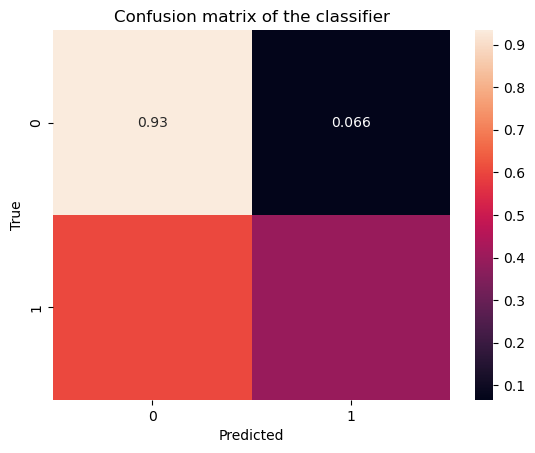

In [62]:
combined_data = pd.concat([X_train, X_test])
X_processed = preprocessor.fit_transform(combined_data)
X_train_processed = X_processed[:X_train.shape[0]]
X_test_processed = X_processed[X_train.shape[0]:]

# Learn the model
#model = KNeighborsClassifier(n_neighbors=15).fit(X_train_processed, Y_train)
#model = GaussianNB().fit(X_train_processed, Y_train)
#model = DecisionTreeClassifier(random_state=0).fit(X_train_processed, Y_train)
model = RandomForestClassifier(max_depth=10, random_state=0).fit(X_train_processed, Y_train)
# model = LogisticRegression(max_iter=1000).fit(X_train_processed, Y_train)  # You can adjust hyperparameters


# # pickle model - saves it so you can load it later
# with open('knn_20_model.obj', 'wb') as f:
#         pickle.dump(model, f)
# # to load pickled model: 
# # with open('filename', 'rb') as f:
# #    model = pickle.load(f)

# Evaluate your model on the testing set
Y_test_predictions = model.predict(X_test_processed)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions) ** 0.5)

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()